In [37]:
# Import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

import seaborn as sns
import pickle
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
# import helper functions
import sys
# add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper_no_cache import *
%matplotlib inline

from sklearn.metrics import roc_curve, auc

from tensorflow.keras.preprocessing import image
from tensorflow.keras import models


# List the files of saved models


In [2]:
# Paths
models_path = '../../efs/models'
checkpoint_path='../../efs/models/Checkpoints/'
training_history_path='../../efs/models/Training_history/'
saved_models_path='../../efs/models/Saved_models/'

In [3]:
os.listdir(checkpoint_path)

['model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.ckpt.data-00000-of-00002',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.ckpt.data-00000-of-00002',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.ckpt.index',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.ckpt.index',
 'model_ALL_FEATURES_sample_size_500_epoch_2_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt.data-00001-of-00002',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10.ckpt.data-00000-of-00002',
 'checkpoint',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10.ckpt.index',
 'model_no_cache_test_sample_size_all_epoch_1_dense_2_neurons_512_los

In [4]:
os.listdir(training_history_path)

['model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.pickle',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10.pickle',
 'model2_sample_sizeall_epoch50_dense2_losswbc_history_log.csv',
 'model_no_cache_test_sample_size_14000_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_history_log.csv',
 'model_Multi_input_sample_size_15000_epoch_10_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.pickle',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended_history_log.csv',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_

# Set the parameter

In [5]:
weights='model_Multi_input_sample_size_15000_epoch_10_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10'

csv = '../1_cleaning/metadata_cleaned3.csv'

number_of_images = 15000

history=weights+'.pickle'

In [6]:
# Create train-test dataset
#name_of_model='model1_sample_sizeall_epoch50_dense2_losswbc'
# Test train split, plus the features that are used to binarize the data
X_train_images, X_val_images, X_train_hier, X_val_hier, y_train_bin, y_val_bin, features = train_test_split_custom_2(number_of_images)


# Load the model

## Option 1 : load the saved model:

In [7]:
# Load the model
new_model = tf.keras.models.load_model('../../efs/models/Saved_models/' + weights + '.h5', \
                                       custom_objects={'weighted_bce': weighted_bce, 
                                                       'accuracy_on_zero': accuracy_on_zero,
                                                       'accuracy_on_one': accuracy_on_one, 
                                                       'precision_on_1': precision_on_1})

## Option 2:  load the architecture + weights

In [ ]:
# Setup the multi-input model from https://www.programcreek.com/python/example/89660/keras.layers.concatenate
num_label = y_train_bin.shape[1]

def getMultiModel():
    
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
    
    # Setup the trainability of the VGG
    base_model.trainable = False if open_layers < 1 else True
    
    for layer in base_model.layers[:-(open_layers+1):]:
        layer.trainable =  False
    
    x = base_model.get_layer('block5_pool').output
    

    x = Flatten()(x)
    
    x = Dense(512, activation='relu', name='fc_1')(x)
    
    input_2 = Input(shape=X_train_hier.shape[1], name="hier")
    
    hier_layer = Dense(32, activation='relu', name = 'fc_hier')(input_2)
    
    merge_one = concatenate([x, hier_layer])
    
    merge_one = Dense(512, activation='relu', name='fc_2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(num_label, activation='sigmoid')(merge_one)
    
    # Define the models
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero, precision_on_1]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model 


In [8]:
# Checkpoint path
# For weights to be saved each epoch
#checkpoint_path = '../../efs/models/Checkpoints/' + weights + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Loads the weights from the checkpoint path above
new_model.load_weights(checkpoint_path+weights+'.ckpt')

# Model architecture

In [8]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

# Predictions for the test dataset

In [9]:
# Create the datasets
# new_model.load_weights(checkpoint_path)
dataset_multi_train = create_dataset_multi(X_train_images,X_train_hier, y_train_bin)
dataset_multi_val = create_dataset_multi(X_val_images,X_val_hier, y_val_bin)

In [10]:
# Make the predictions
#%%time
# Takes 2:30 with 1000 images, 
# grab the predictions from the valadation ds
predictions_test = new_model.predict(dataset_multi_val)
#predictions_train = new_model.predict(train_ds)

# SAVE the prediction
#pickle.dump([predictions_test], open( "predictions.p", "wb" ) )

In [ ]:
# Optional step - load the predictions from file
#pickle.dump([predictions_test], open( "predictions.p", "wb" ) )
# Load the prediction
#predictions_test= pickle.load( open( "predictions.p", "rb" ) )

# Evaluations

## Loss plots

In [11]:
# Load the training history
history=pickle.load(open(training_history_path+history, "rb" ))


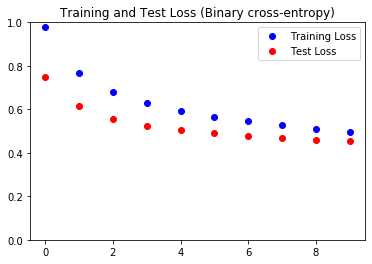

In [12]:
# Plot the training history
plot_training_history_loss(history)

## Model prediction on features that are present in photo

In [13]:
def plot_per_feature_error(predictions, actual, features, diff=False):
    
    """return plot of boxplot of predictions when the feature is active"""
    
    only_ones = np.array([np.where(y_true == 1, pred, np.nan) for y_true, pred in zip(actual,
                                                                                  predictions)])
    pred_df = pd.DataFrame(only_ones)
    
    # Name the classes 
    pred_df.columns = features

    # order the whole dataframe and return the column names
    order = pred_df.median().sort_values().keys()
    fig_dims = (22,10)
    fig, ax = plt.subplots(figsize=fig_dims)
    
    melted=pred_df.melt()
    #melted_with_medians = melted.merge(medians_per_feature, on='variable', how='left')
    #melted_with_medians['avg_prediction']=melted_with_medians['median']>0.5
    #my_pal = {"g", "r"}
    #boxprops = dict(linestyle='-', linewidth=4, color='grey', alpha=.1)
    
    sns.boxplot(x='variable', y='value', data=pred_df.melt(), whis=0, showfliers=False, order=order, boxprops=dict(alpha=.1))
    #sns.boxplot(x='variable', y='value', boxprops=boxprops, data=melted_with_medians, whis=0, hue='avg_prediction', palette=my_pal, showfliers=False, order=order)
    #boxprops=dict(alpha=.3)

    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
    ax.set_xlabel('Fashion features', fontsize=30)
    ax.set_ylabel('Raw probabilities if the label is ON', fontsize=30)
    ax.set_title('Raw probabilities per feature if the label is ON', fontsize=40)
    ax.set(xticklabels=[])

    
    if diff:
        only_zeros = np.array([np.where(y_true == 0, pred, np.nan) for y_true, pred in zip(actual,
                                                                                  predictions)])
        pred_df2 = pd.DataFrame(only_zeros)
        pred_df2.columns = features
        
        pred_df=pred_df.reindex(pred_df.median().sort_values().index, axis=1)
        pred_df2=pred_df2.reindex(pred_df.median().sort_values().index, axis=1)
        
        
        median_ones=pred_df.median()
        median_zeros=pred_df2.median()
        diff=median_ones-median_zeros
        diff=pd.DataFrame(diff)

        sns.scatterplot(data=diff)

    return fig, ax

In [14]:
len(features)

184

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f123142b8d0>)

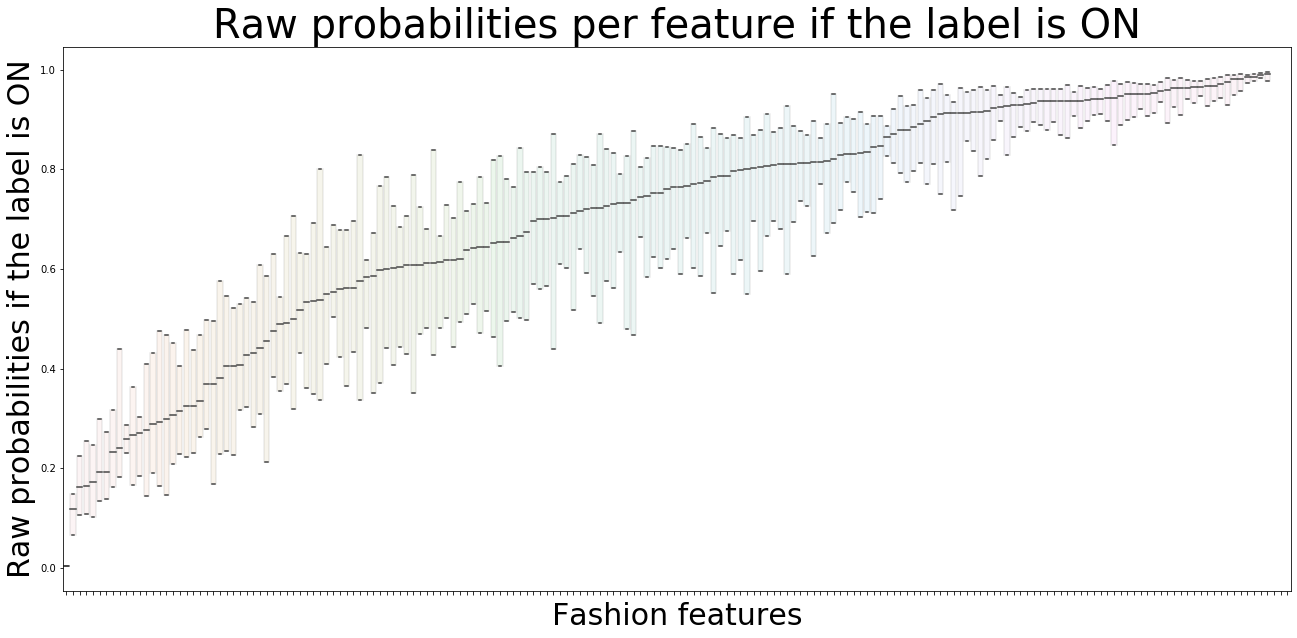

In [15]:
# Plot the predictions on 1s + the differences of medians 
plot_per_feature_error(predictions_test, y_val_bin, features, diff=False)

In [20]:
only_ones = np.array([np.where(y_true == 1, pred, np.nan) for y_true, pred in zip(y_val_bin,
                                                                              predictions_test)])
pred_df = pd.DataFrame(only_ones)

# Name the classes 
pred_df.columns = features

# order the whole dataframe and return the column names
order = pred_df.median().sort_values()

## Recall on 1, recall on 0

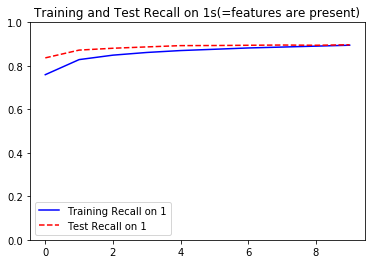

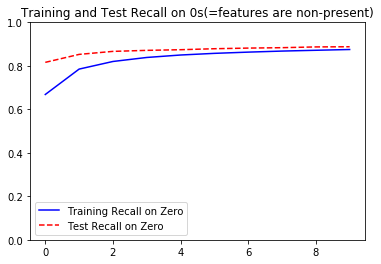

In [16]:
plot_training_history_recall_on_one(history)
plot_training_history_recall_on_zero(history)

# Precision

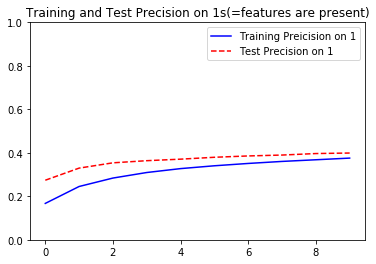

In [17]:
plot_training_history_precision_on_one(history)

## Precision - Recall curve with F1

In [18]:
import copy

[]

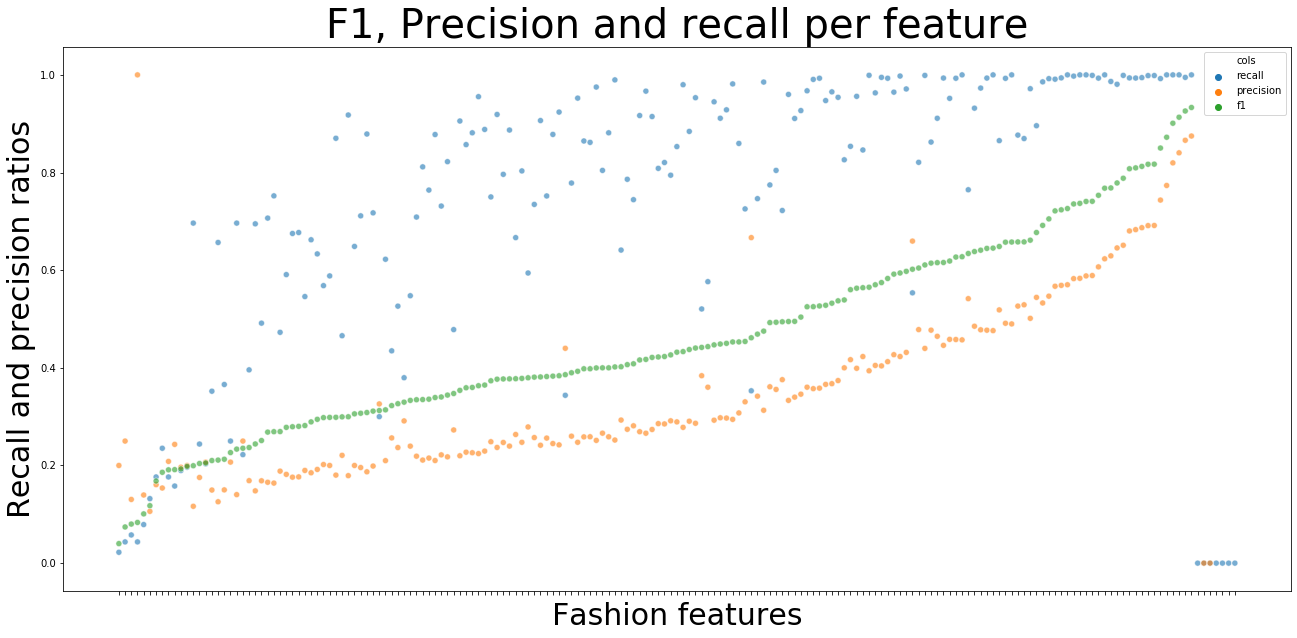

In [19]:

predictions_conv=copy.deepcopy(predictions_test)

predictions_conv[predictions_conv >= 0.5] =1 
predictions_conv[predictions_conv < 0.5] =0


true_pos=np.logical_and(predictions_conv, y_val_bin)
true_pos_df=pd.DataFrame(true_pos)
true_pos_df.columns = features
true_pos_per_feature=true_pos_df.sum(axis=0) 

true_ones=pd.DataFrame(y_val_bin)
true_ones.columns = features
true_ones_per_feature=true_ones.sum(axis=0) 

recall=true_pos_per_feature/true_ones_per_feature
recall_sorted=recall.sort_values()

precision_df=pd.DataFrame(predictions_conv)
precision_df.columns = features
all_1_predictions_per_feature=precision_df.sum(axis=0) 
precision=true_pos_per_feature/all_1_predictions_per_feature


combined=pd.concat([recall, precision], axis=1)
combined.columns= ['recall', 'precision']
#combined=combined.sort_values(by='recall')
combined['features']=combined.index

#F1 Score = 2*(Recall * Precision) / (Recall + Precision)
combined['f1']= 2*combined['recall']*combined['precision']/(recall+precision)
combined=combined.sort_values(by='f1')

combined_melt= combined.melt('features', var_name='cols', value_name='vals')

fig_dims = (22,10)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.scatterplot(x='features', y="vals", hue='cols', data=combined_melt, alpha=0.6)
g.set_xlabel('Fashion features', fontsize=30)
g.set_ylabel('Recall and precision ratios', fontsize=30)
g.set_title('F1, Precision and recall per feature', fontsize=40)
g.set_xticklabels([],rotation=90)


## Make a prediction for an image

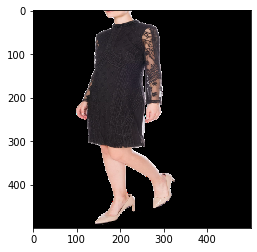

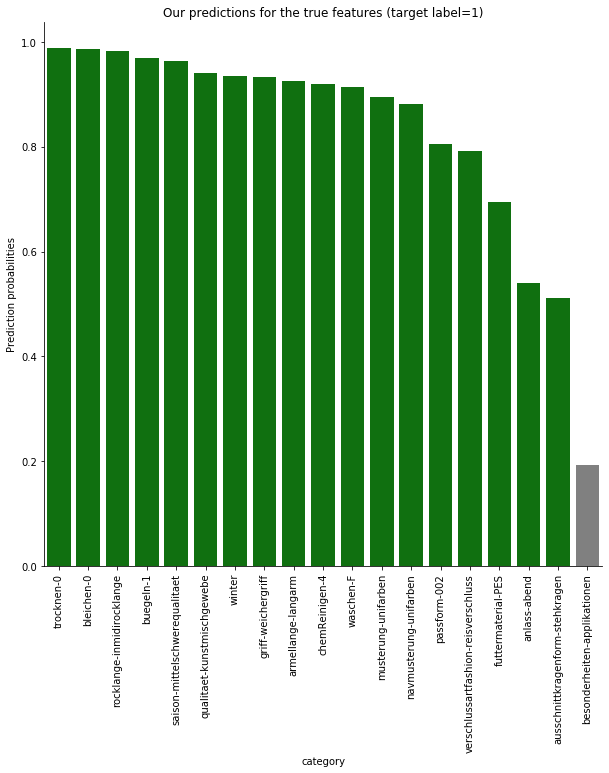

In [23]:
doPrediction(0, features, X_val_images, y_val_bin, predictions_test)

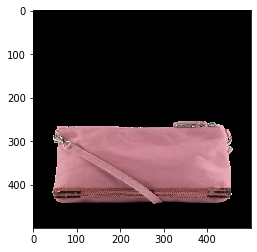

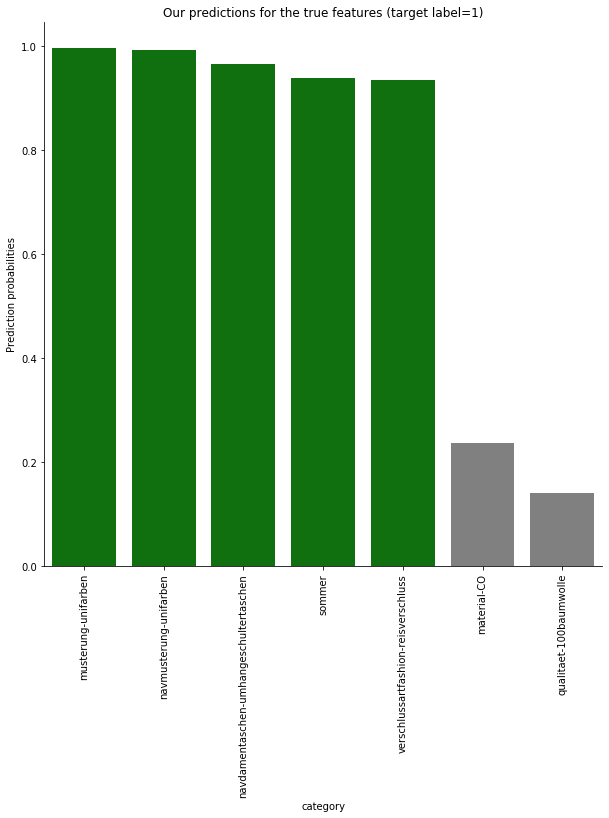

In [26]:
doPrediction(1,features, X_val_images, y_val_bin, predictions_test)

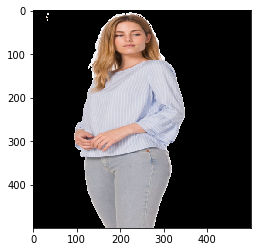

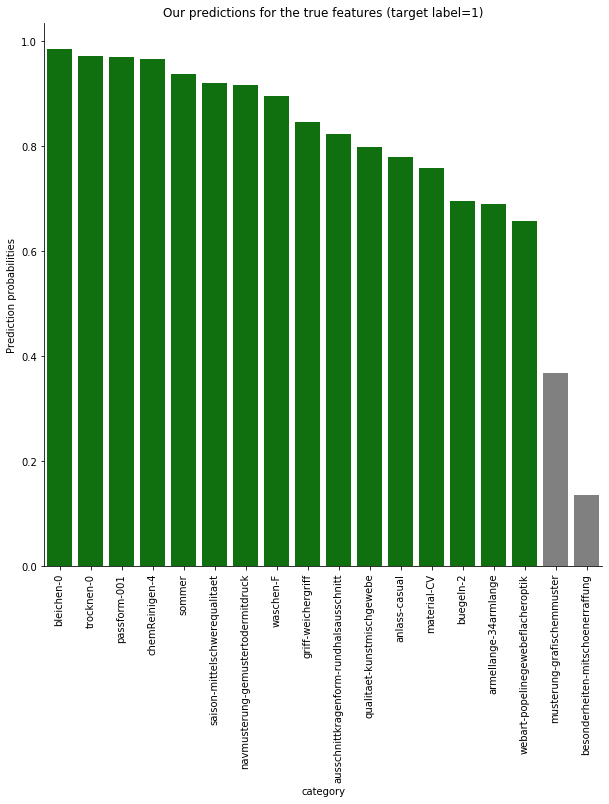

In [27]:
doPrediction(3,features, X_val_images, y_val_bin, predictions_test)

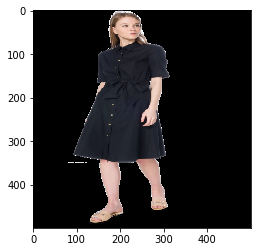

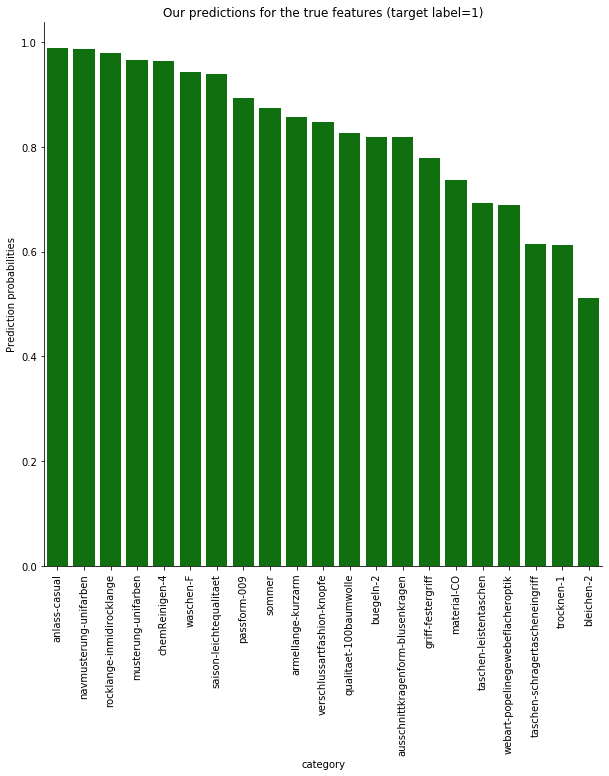

In [28]:
doPrediction(4,features, X_val_images, y_val_bin, predictions_test)

## ROC AUC curve

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f122f6f09b0>)

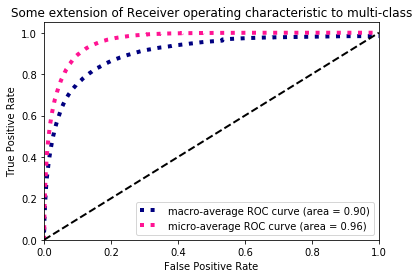

In [29]:
grouped_roc(y_val_bin, predictions_test)

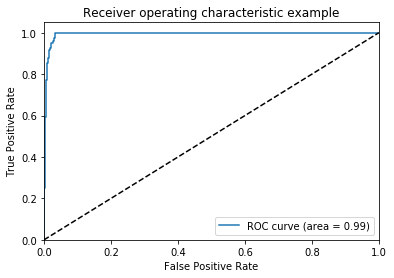

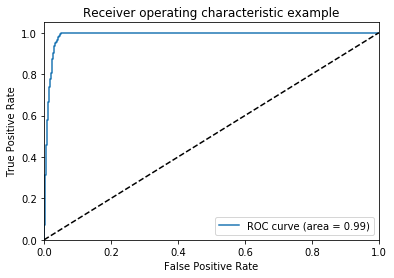

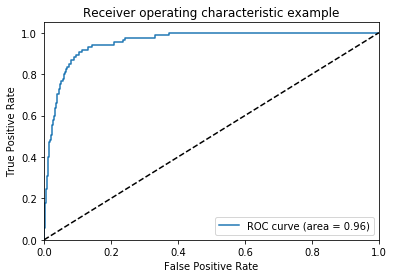

In [30]:
# Plot 3 ROC curves for 3 features
n_classes = y_val_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

    
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [31]:
# ROC AUC scores per feature
for i in range(119):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


{0: 0.994401914822068,
 1: 0.9882042957042957,
 2: 0.9556048834628191,
 3: 0.9643975767884513,
 4: 0.9417551224261428,
 5: 0.9978849768000966,
 6: 0.7661843400172224,
 7: 0.9653193224023916,
 8: 0.9877946482307853,
 9: 0.8656850745194039,
 10: 0.9345252173913045,
 11: 0.9861534641085843,
 12: 0.9861501821599146,
 13: 0.9741530111835416,
 14: 0.9471785294461887,
 15: 0.972953464673913,
 16: 0.9602023673157694,
 17: 0.9519197891519264,
 18: 0.8954678134365633,
 19: 0.9297898016895116,
 20: 0.816203727951489,
 21: 0.8006033699929371,
 22: 0.97599099809557,
 23: 0.969076404309565,
 24: 0.9075615717240083,
 25: 0.9688162158089068,
 26: 0.8250305087012487,
 27: 0.9598079795448217,
 28: 0.9350925192598459,
 29: 0.9759727896553092,
 30: 0.9213447293447293,
 31: 0.9770098129356893,
 32: 0.9664794249311295,
 33: 0.890686505897604,
 34: 0.8483269469184963,
 35: 0.7031003451232429,
 36: 0.783408280206436,
 37: 0.9355987941901891,
 38: 0.8542091440236347,
 39: 0.8573897642304721,
 40: 0.83783978444

## Visualizing the CNN layers - how the model sees an image 

In [54]:
layer_outputs = [layer.output for layer in new_model.layers[1:23]] 
# Extracts the outputs of the top 12 layers

activation_model = models.Model(inputs=new_model.input[0], outputs=layer_outputs)
# Creates a model that will return these outputs, given the model input

In [47]:
new_model.layers[19]

In [32]:
df_test = pd.read_csv('../1_cleaning/metadata_cleaned2.csv')

img_path1=df_test['image_path'][0]



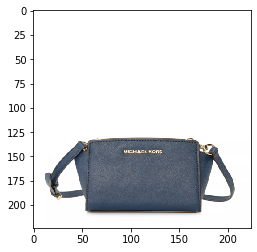

(1, 224, 224, 3)


In [35]:
img = image.load_img(img_path1, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [52]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


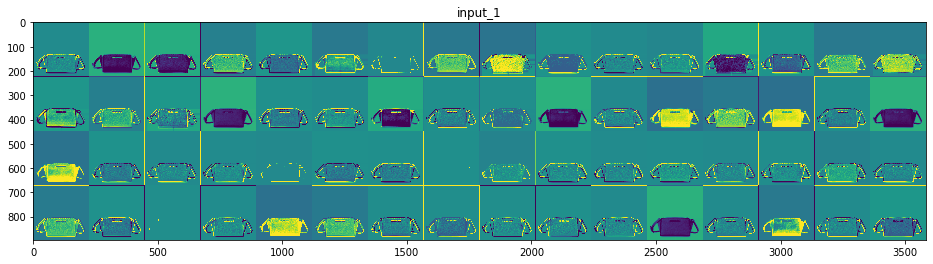

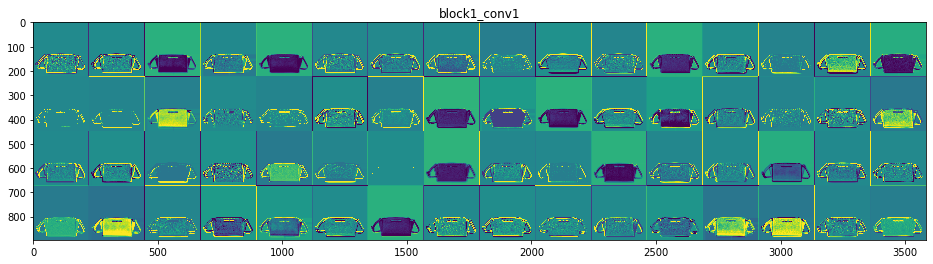

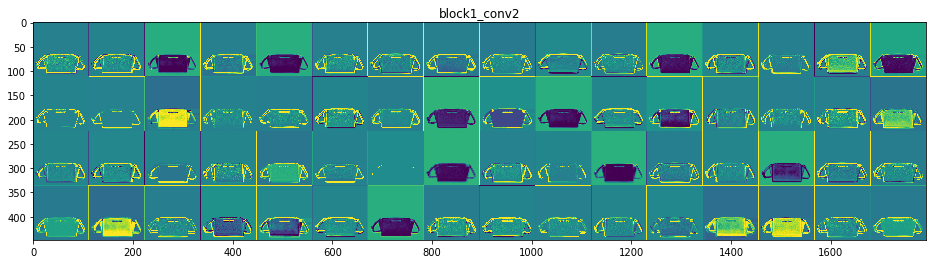

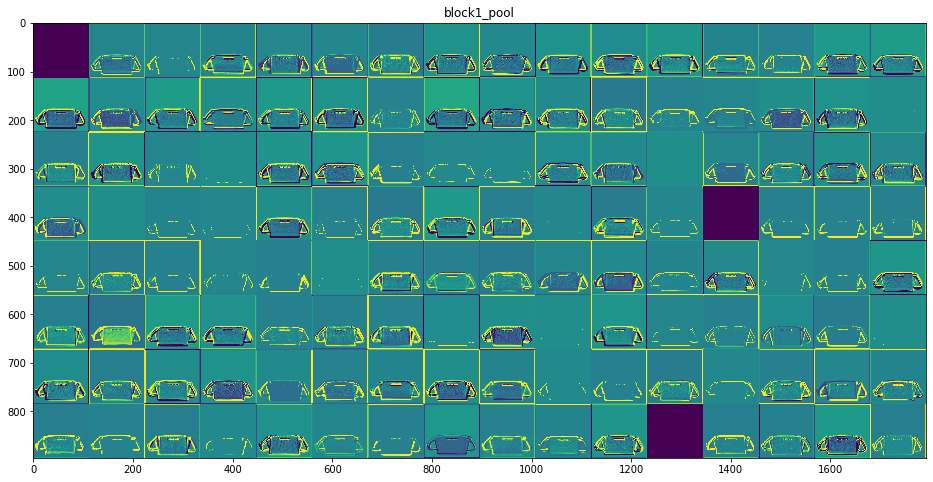

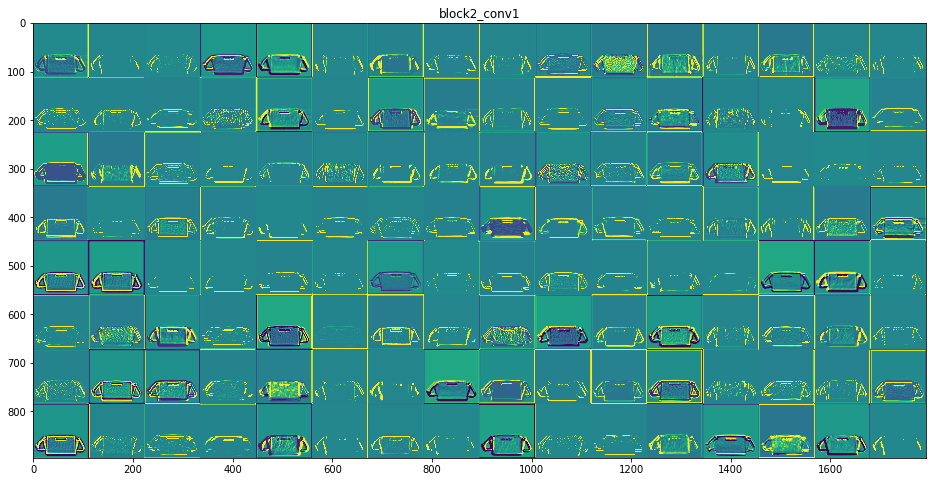

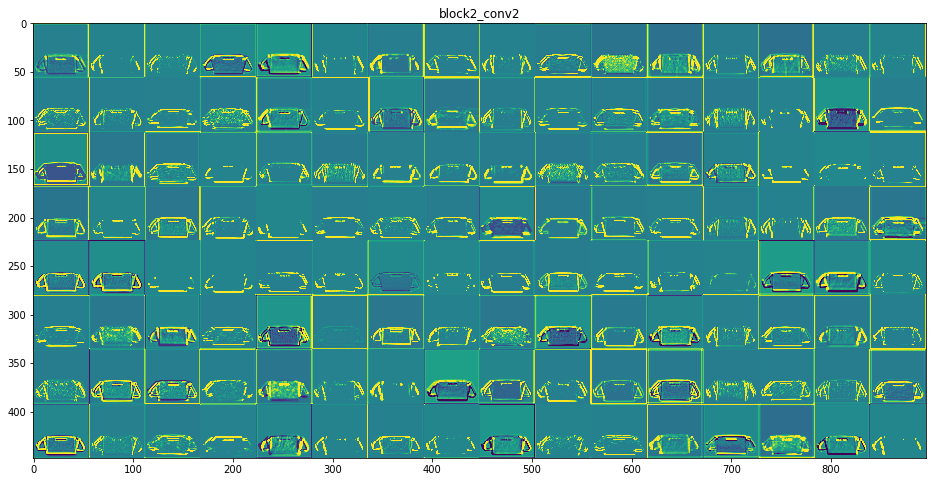

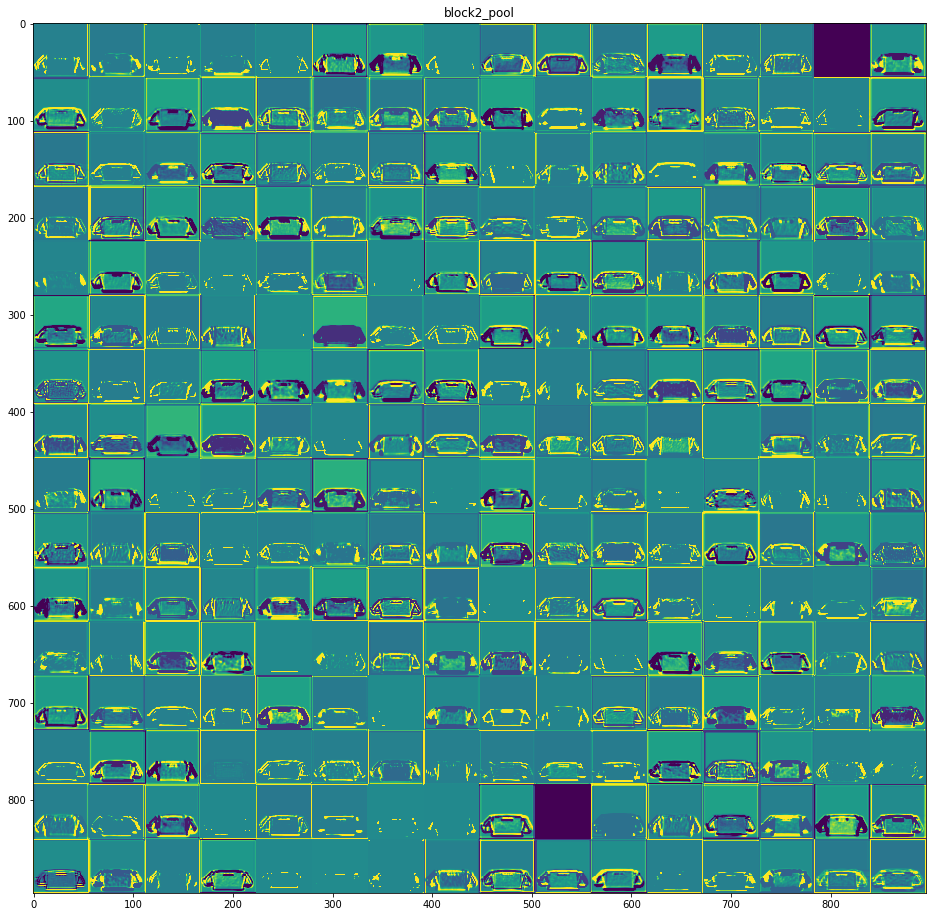

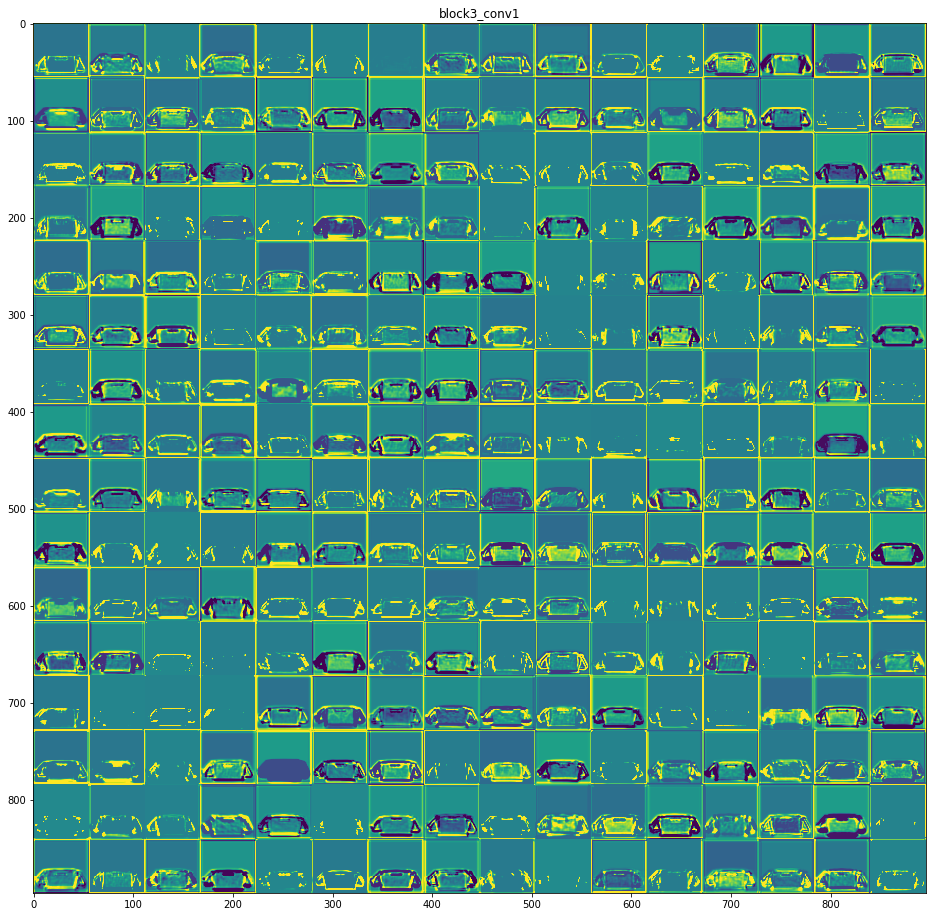

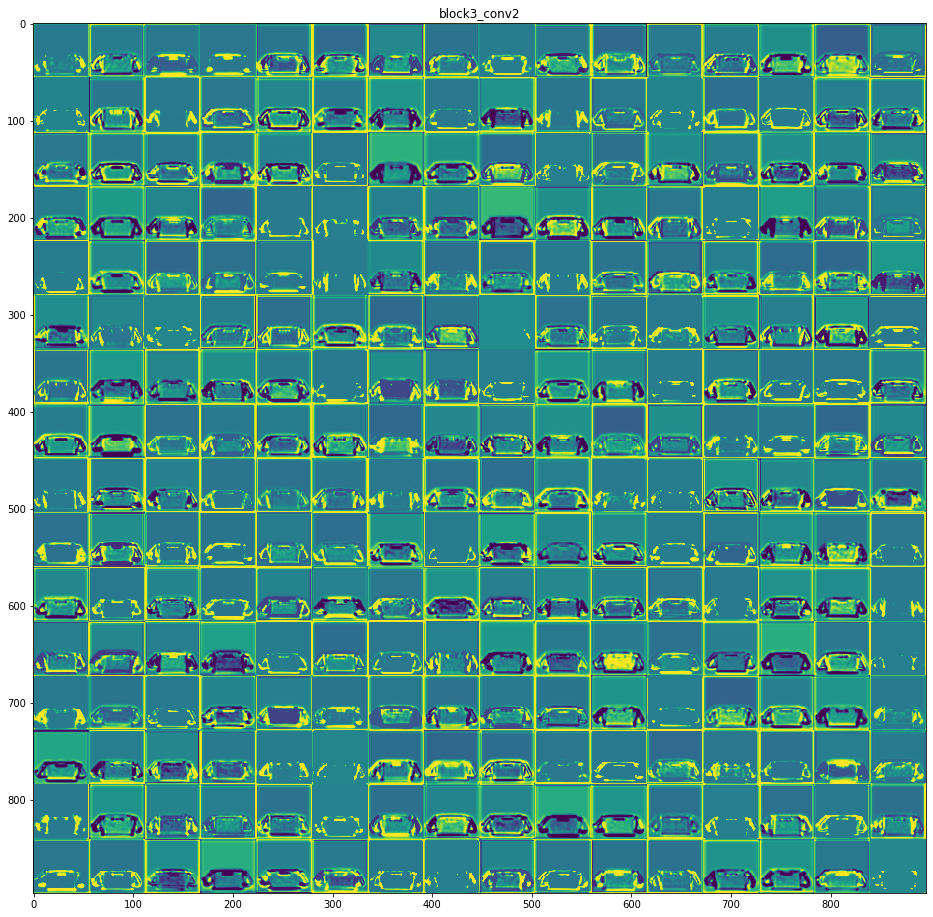

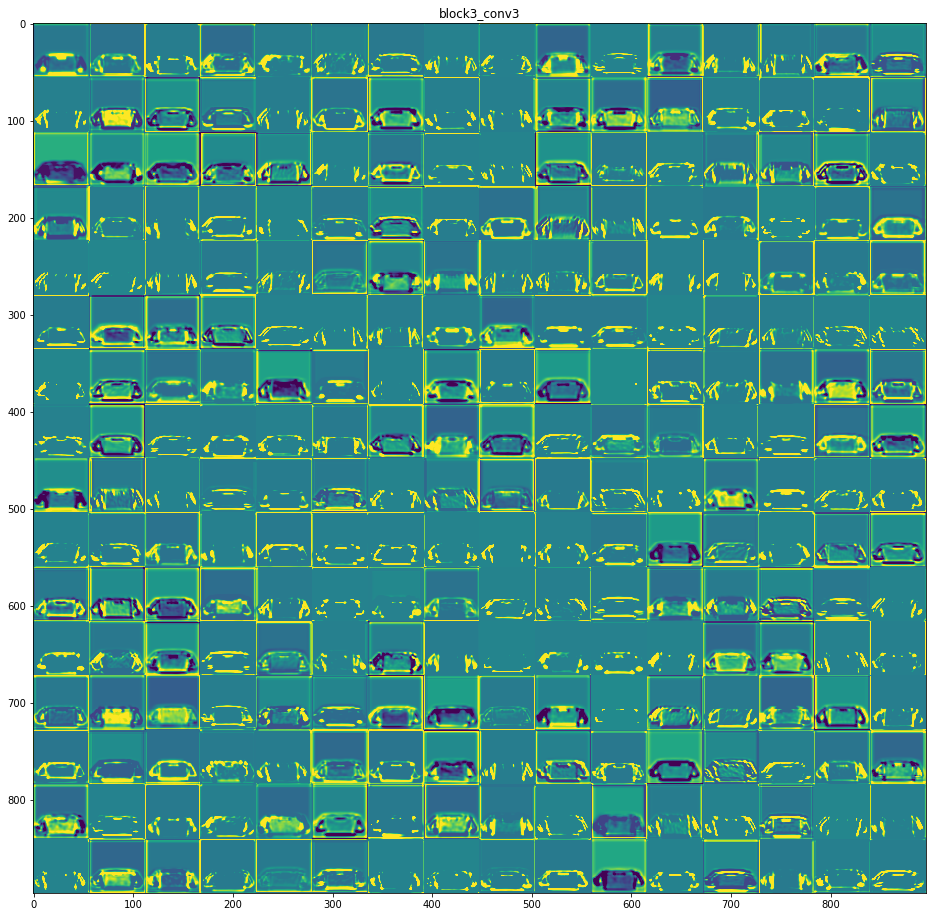

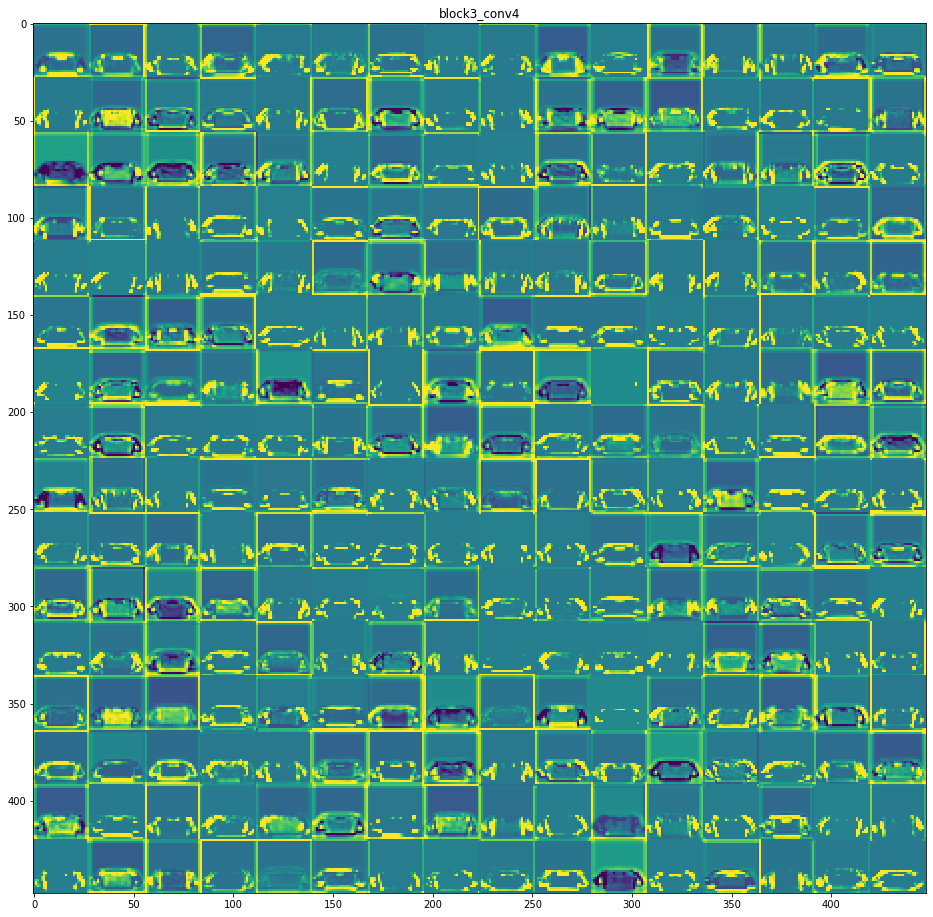

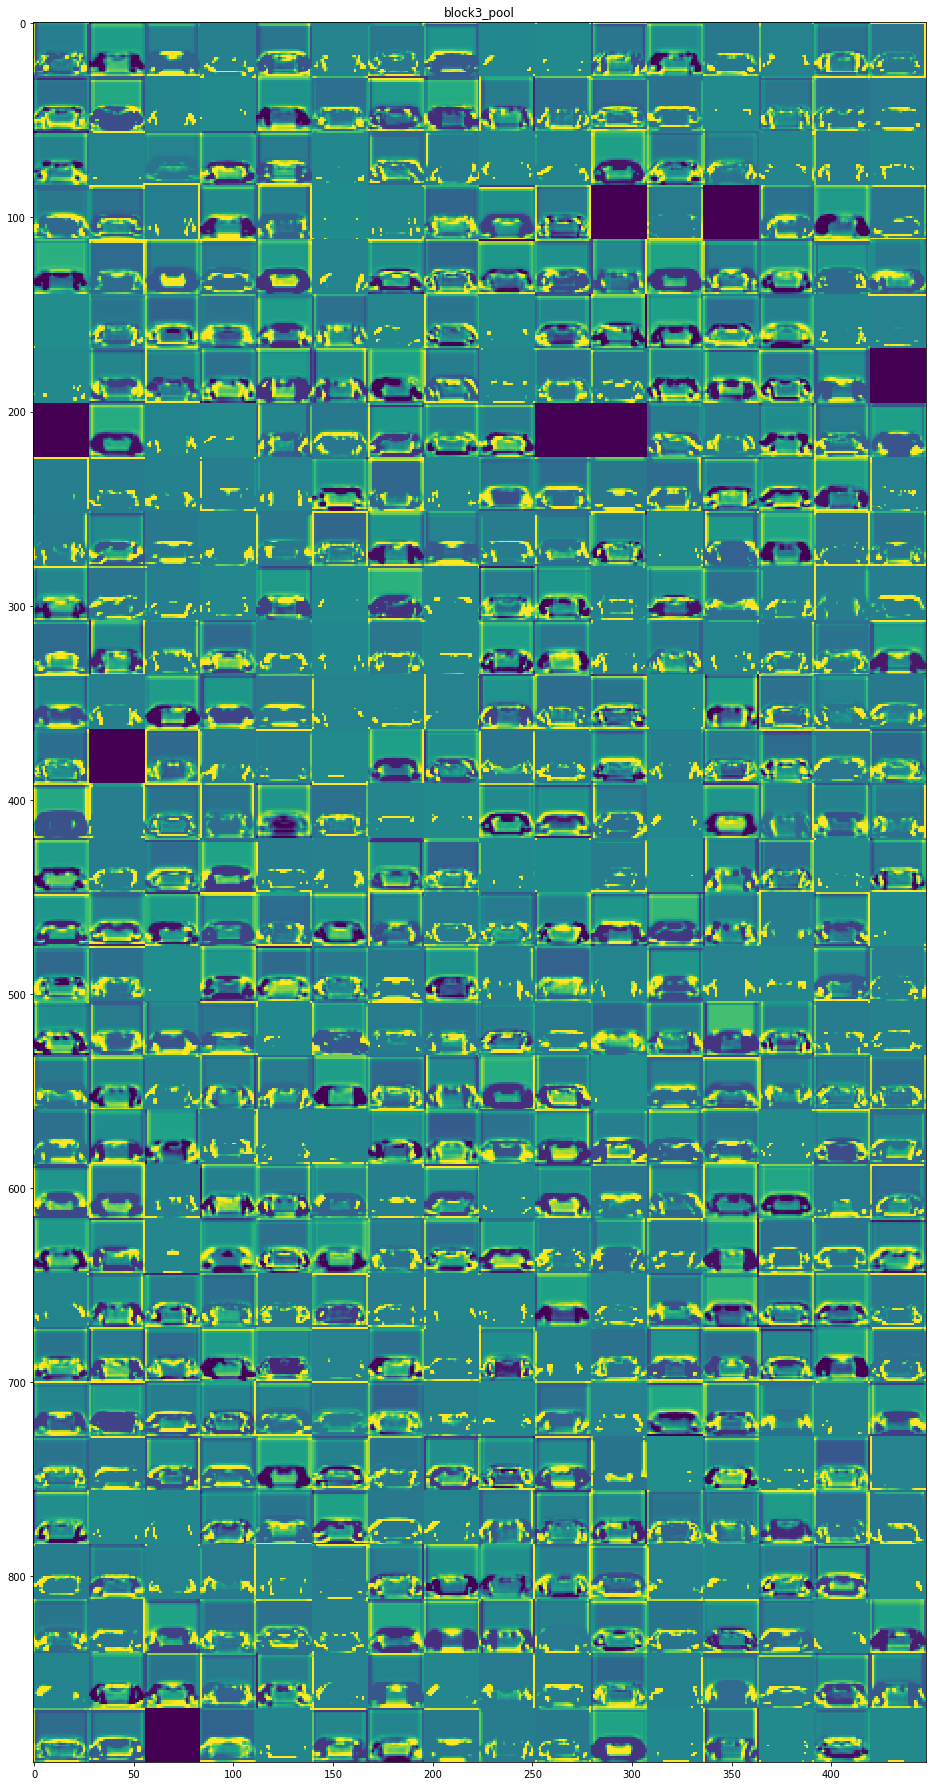

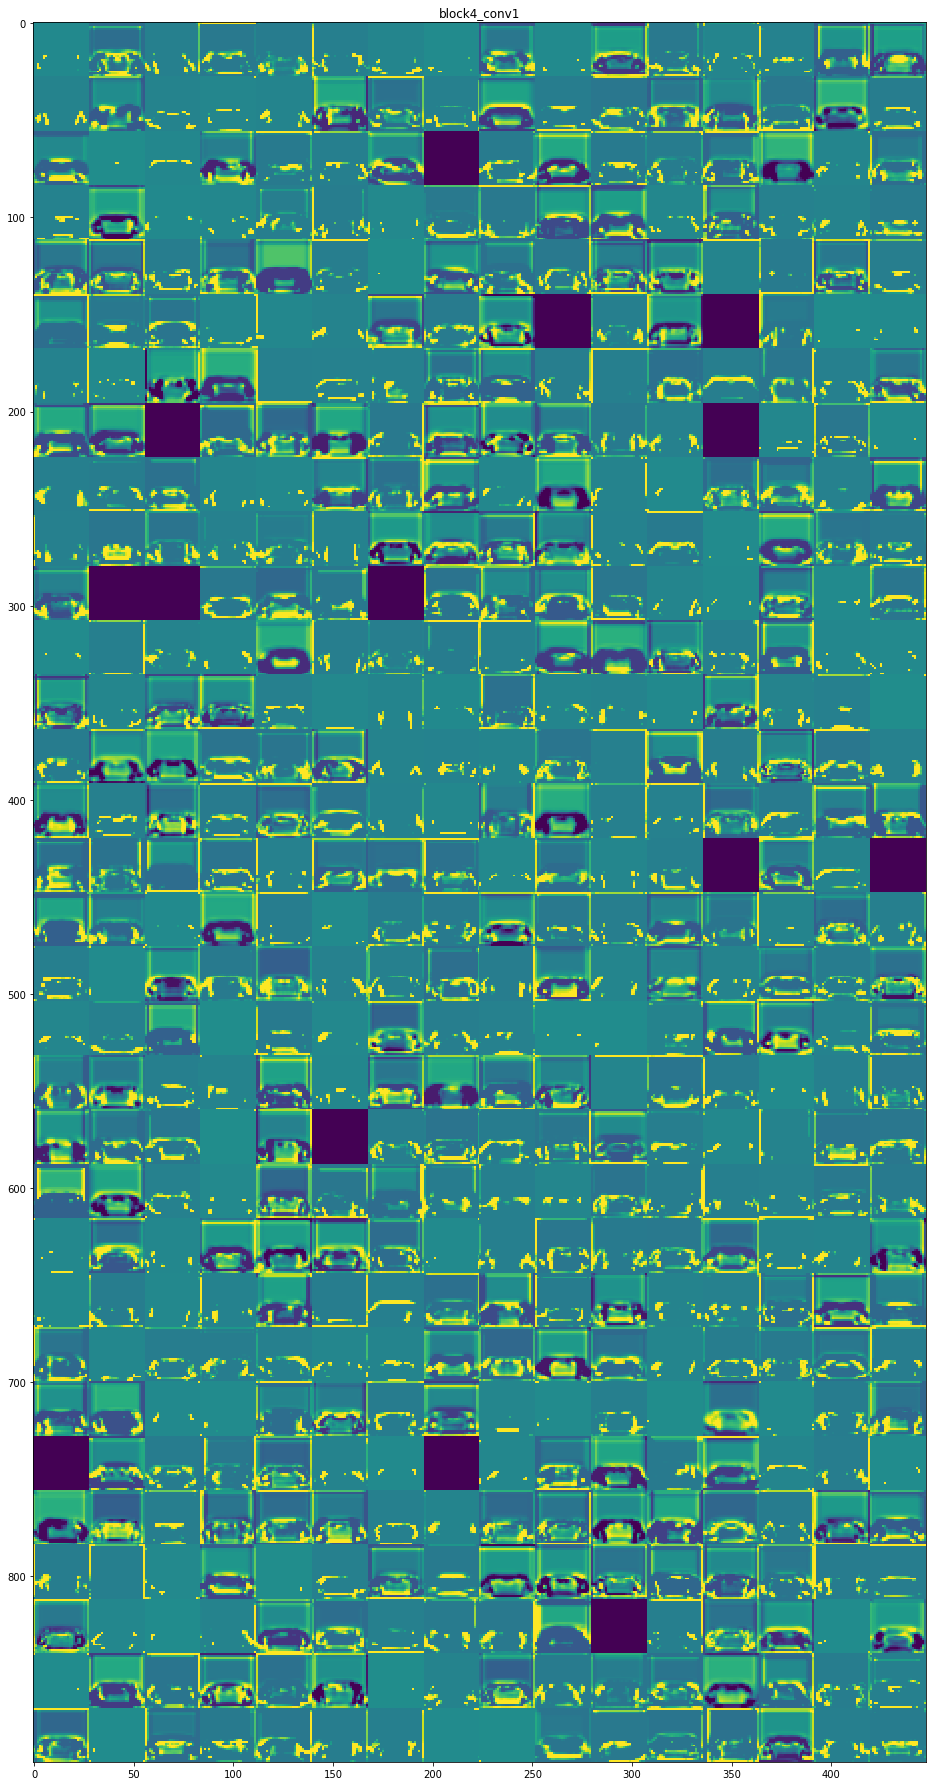

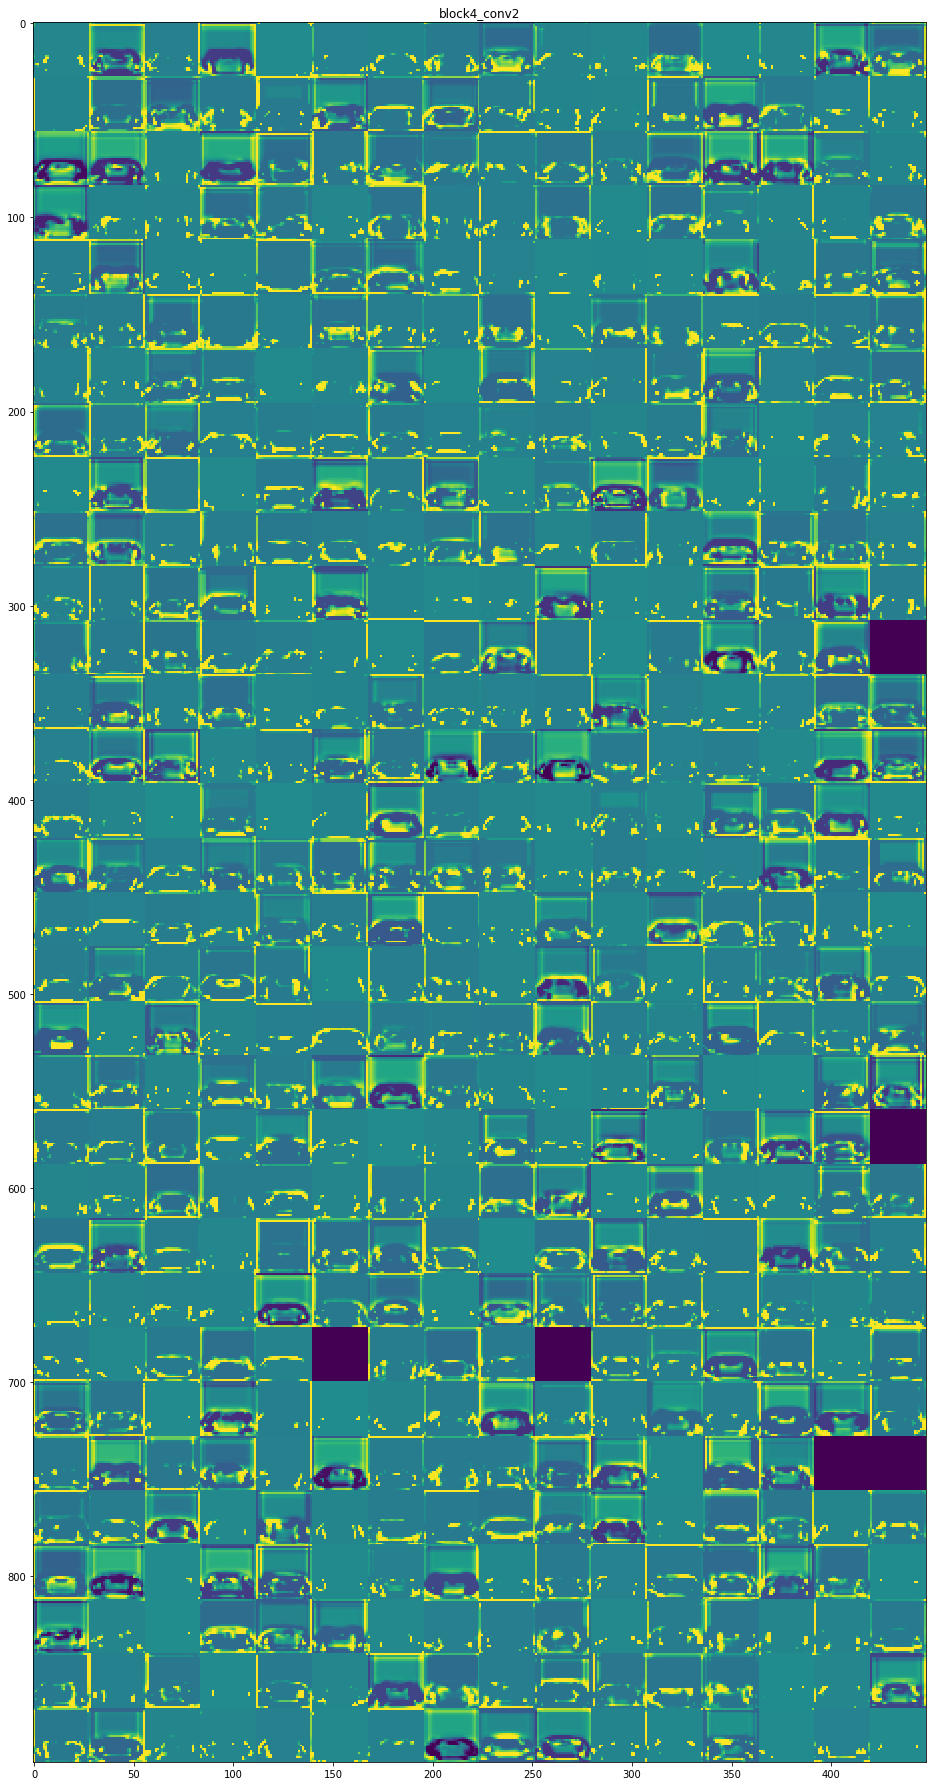

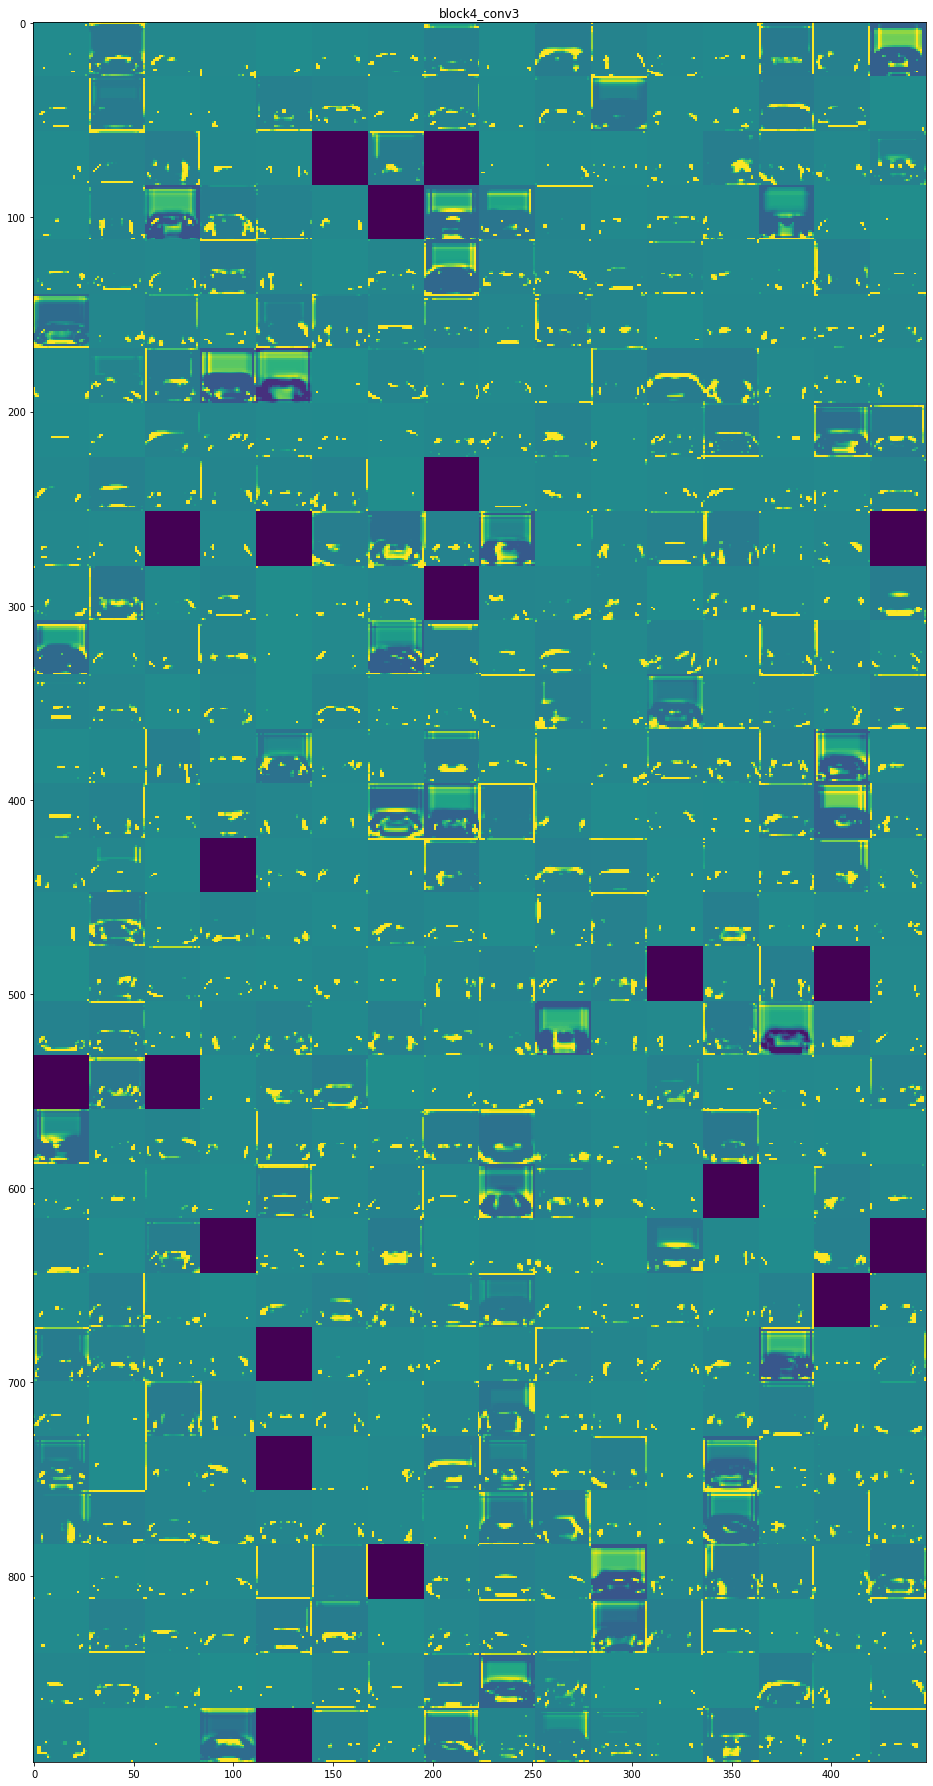

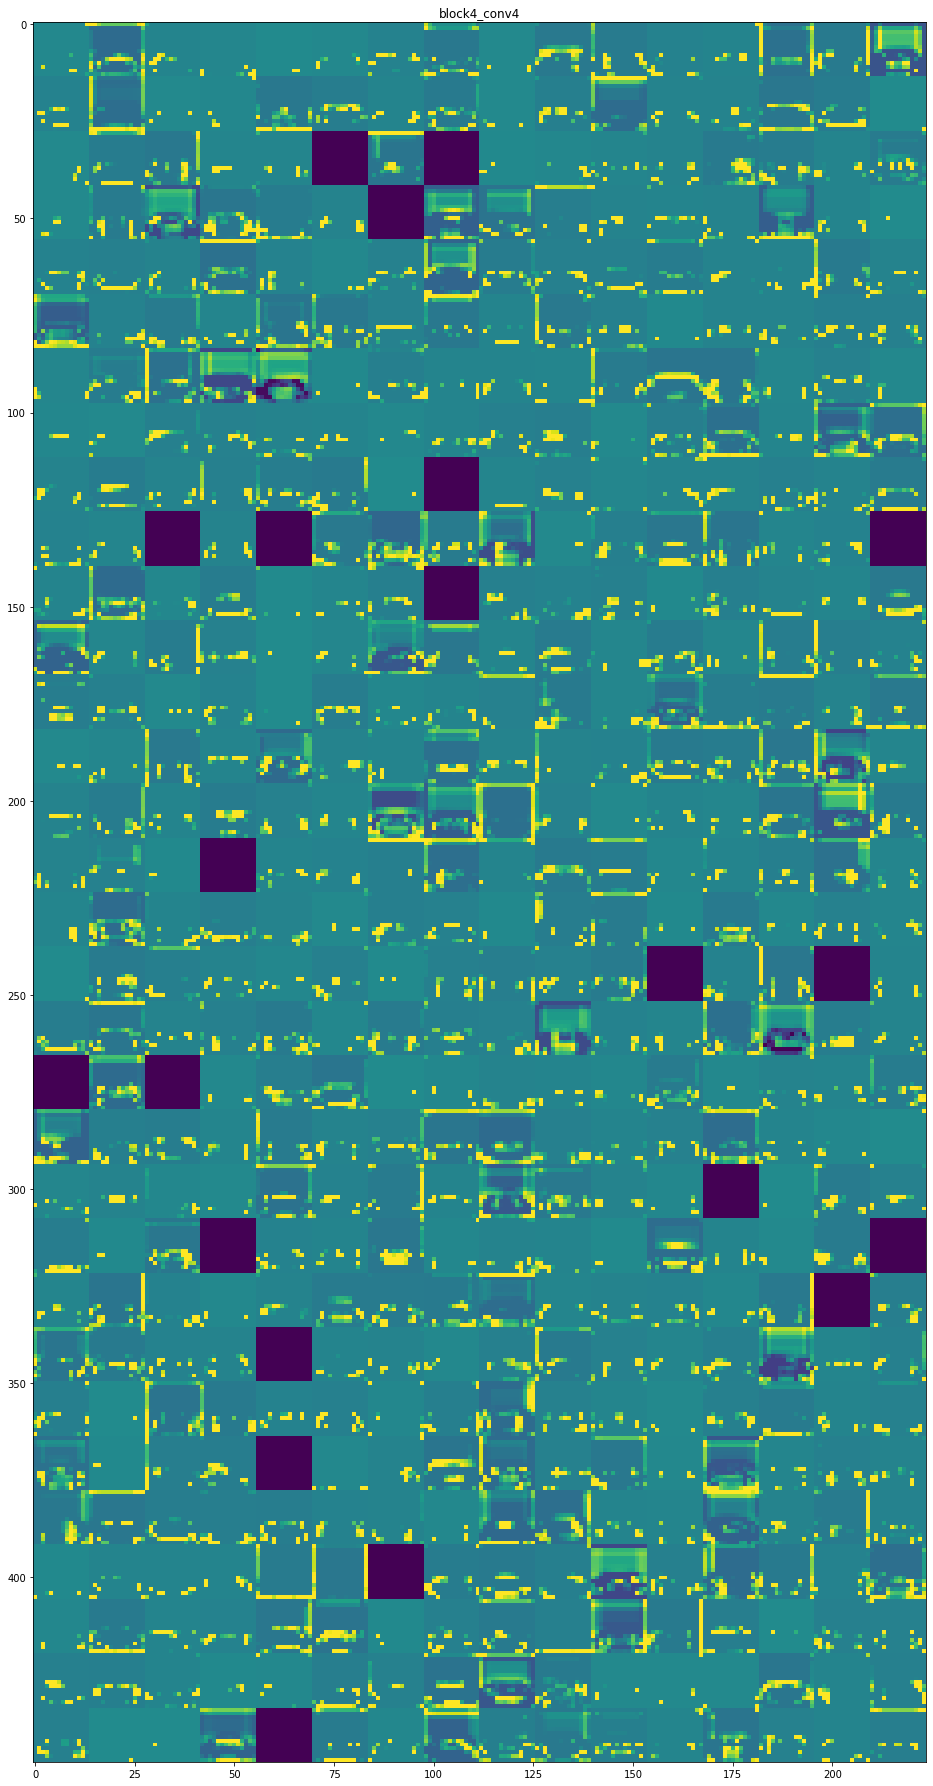

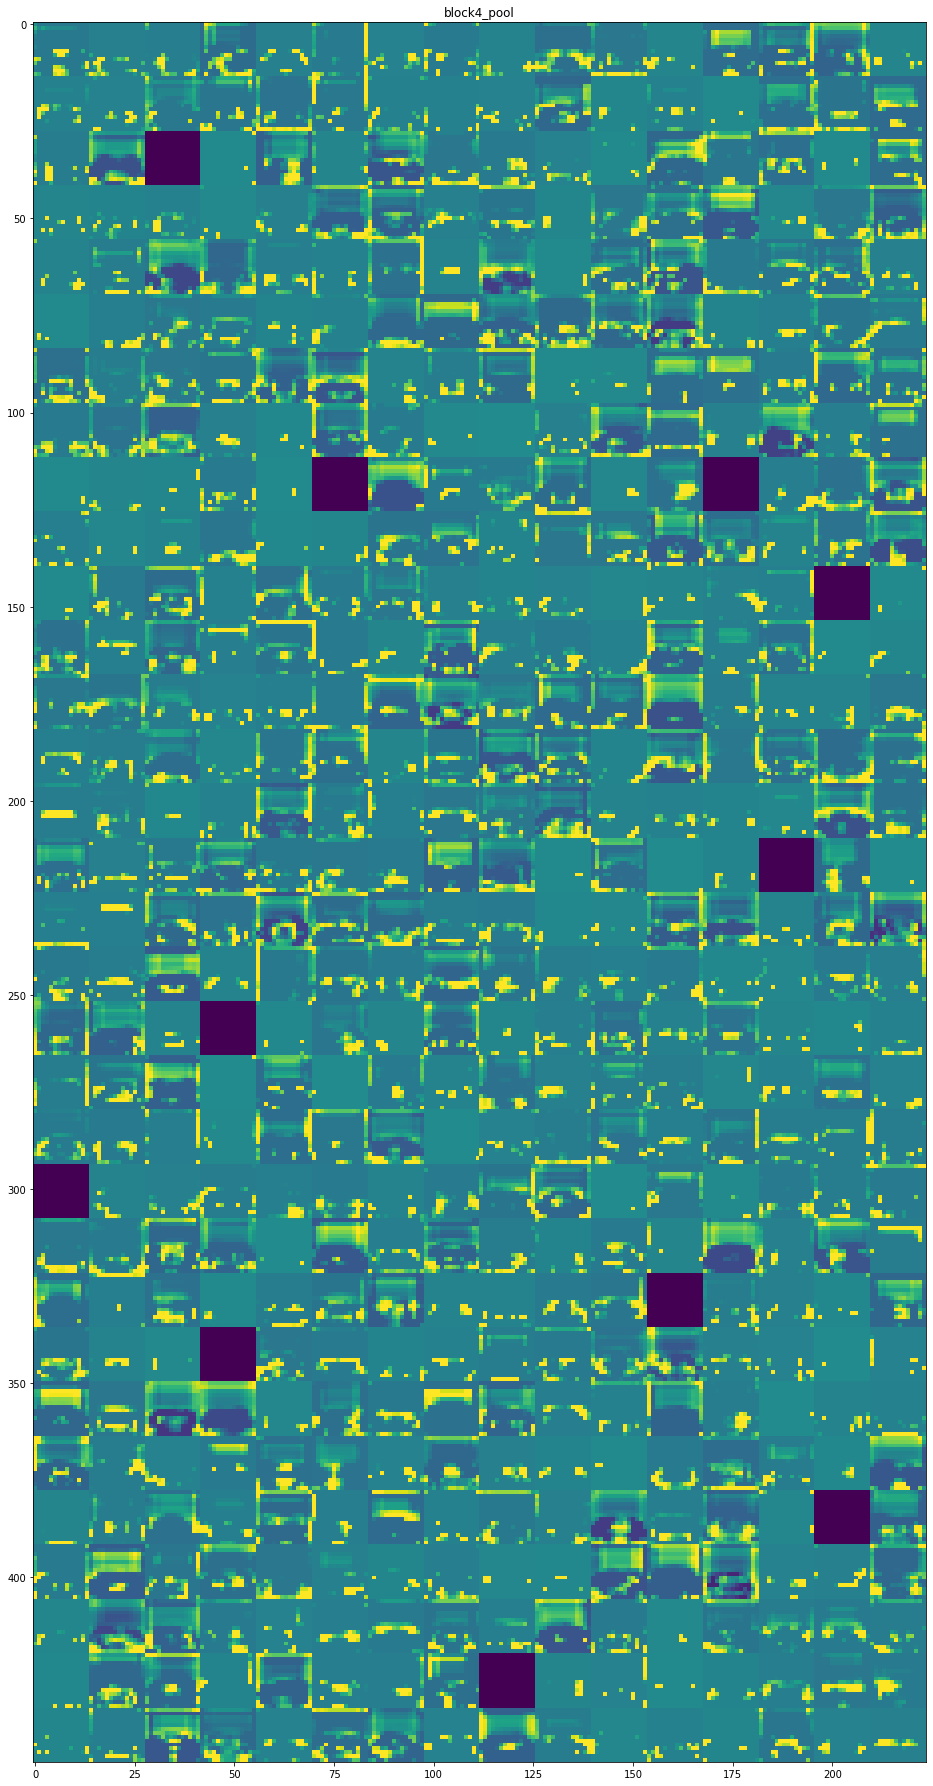

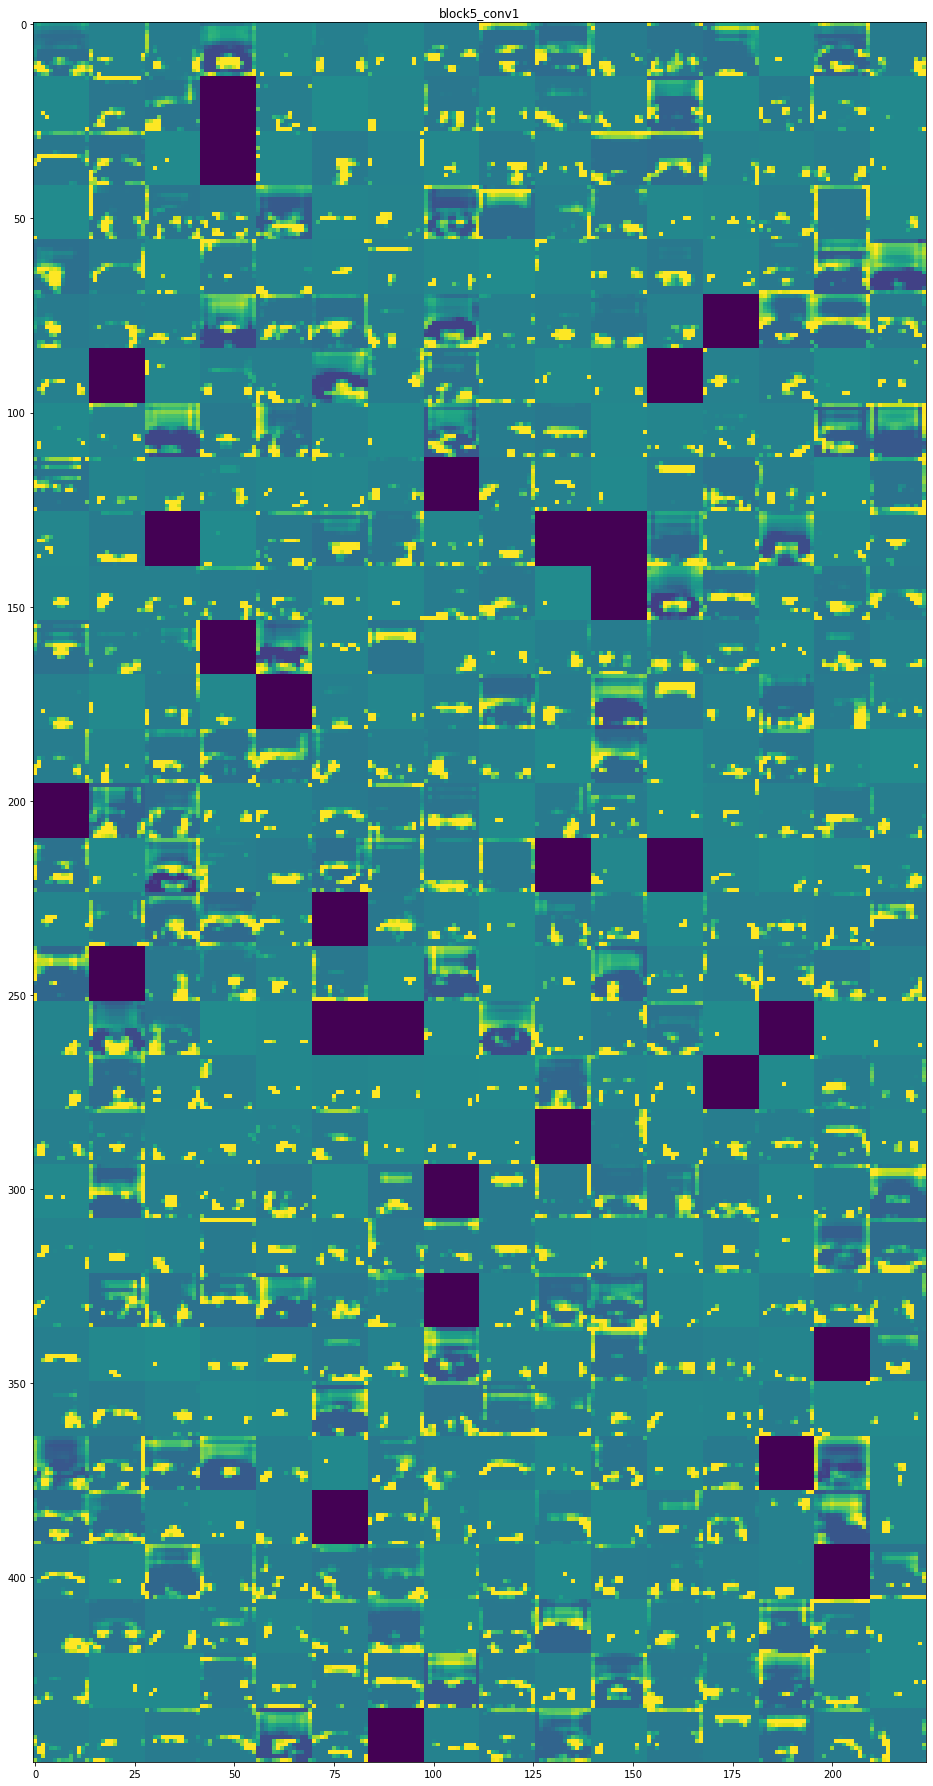

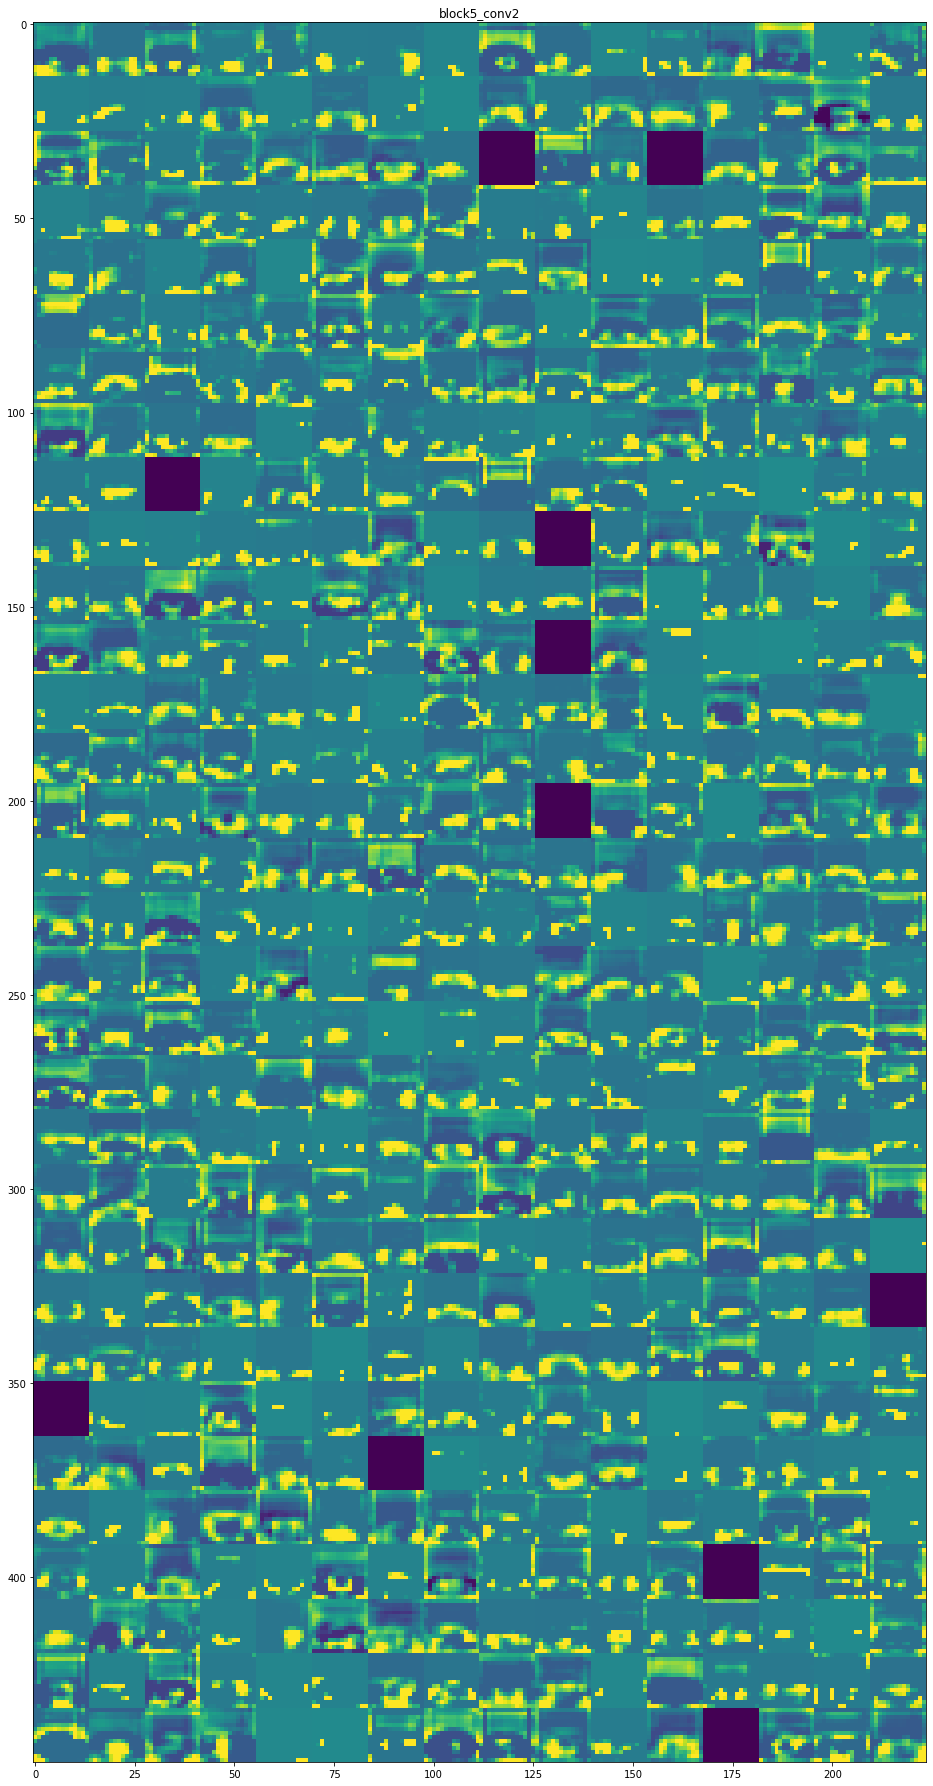

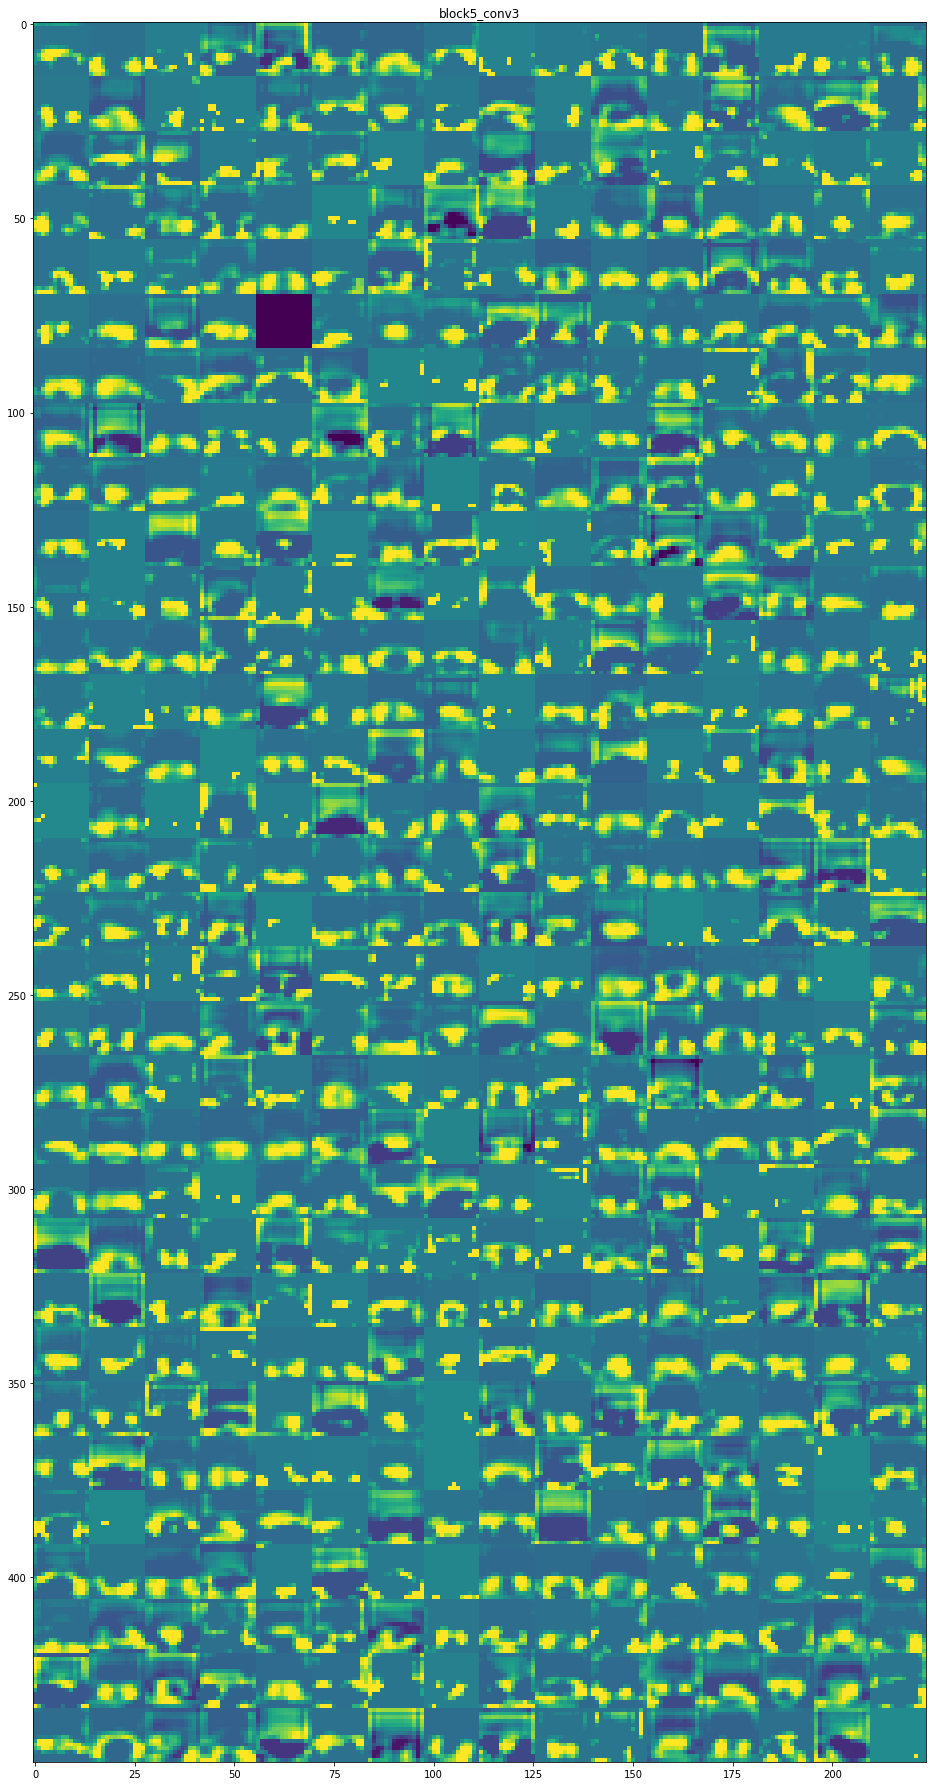

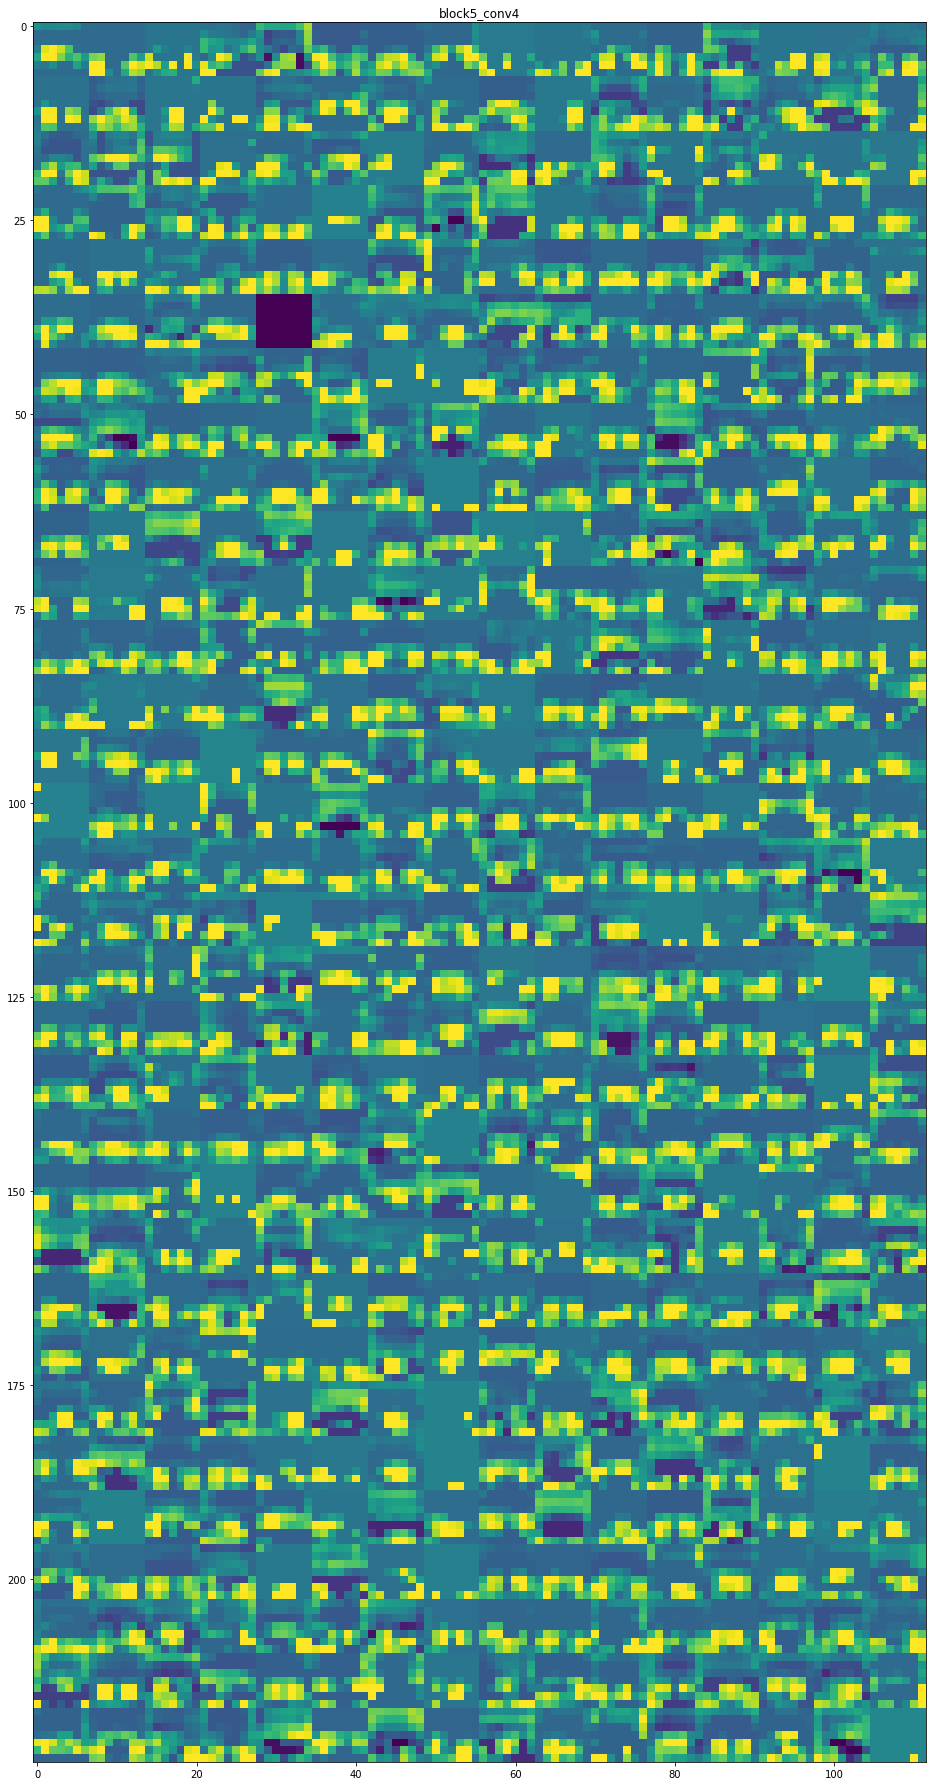

In [55]:
layer_names = []
for layer in new_model.layers[:23]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')